# CNN Hyperparameter Tuning with Genetic Algorithms

## Introduction

Convolutional Neural Networks (CNNs) have become the standard approach for image classification tasks. However, designing effective CNN architectures remains challenging due to the vast search space of hyperparameters. Manual tuning is time-consuming and may result in suboptimal architectures, while traditional methods like grid search and random search scale poorly with the number of hyperparameters.

In this notebook, we explore using **genetic algorithms** to automatically optimize CNN hyperparameters for image classification on the CIFAR-10 dataset. Genetic algorithms provide a biologically-inspired approach that can efficiently navigate complex hyperparameter spaces through evolutionary principles.

### Objectives

- Implement a genetic algorithm framework for CNN hyperparameter tuning
- Compare the genetic algorithm approach with traditional methods (grid search, random search)
- Analyze the impact of different genetic algorithm components and parameters
- Understand the evolutionary trajectory of CNN architectures
- Visualize and interpret the results

### The CIFAR-10 Dataset

CIFAR-10 consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images. The classes are:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

Let's start by setting up our environment and exploring the dataset.

In [7]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import random
import time
from typing import List, Dict, Tuple, Any, Optional
import os
import pandas as pd
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

## Data Loading and Exploration

First, let's load the CIFAR-10 dataset and explore its structure.

In [8]:
def load_data():
    """Load and preprocess CIFAR-10 dataset."""
    # Load CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize pixel values to be between 0 and 1
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Create a validation set
    val_size = 5000
    x_val = x_train[-val_size:]
    y_val = y_train[-val_size:]
    x_train = x_train[:-val_size]
    y_train = y_train[:-val_size]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Load and examine the dataset
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

Training set: (45000, 32, 32, 3), (45000, 10)
Validation set: (5000, 32, 32, 3), (5000, 10)
Test set: (10000, 32, 32, 3), (10000, 10)


Let's visualize some example images from the dataset to understand what we're working with.

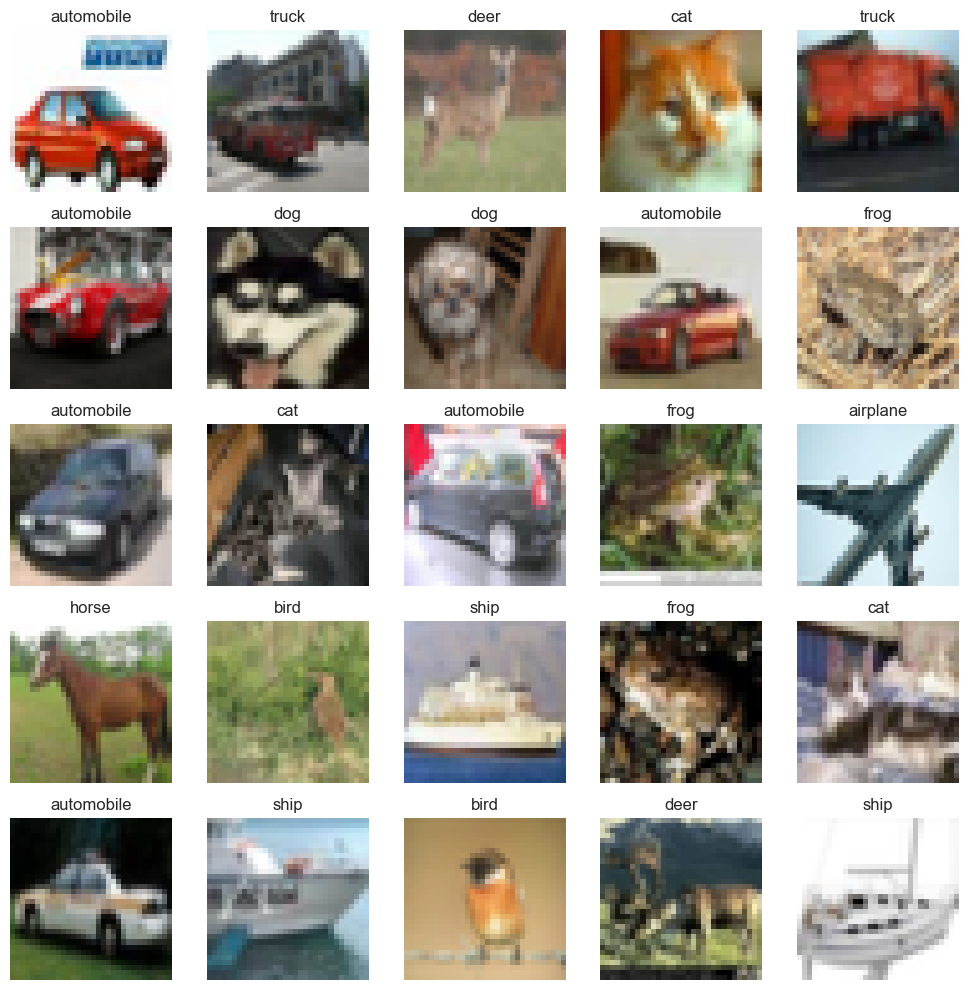

In [9]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to display multiple images with their labels
def plot_images(images, labels, num_images=25):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            # Display image
            ax.imshow(images[i])
            # Get label (convert from one-hot)
            label_idx = np.argmax(labels[i])
            ax.set_title(class_names[label_idx])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select random images from the training set
indices = np.random.choice(len(x_train), 25, replace=False)
sample_images = x_train[indices]
sample_labels = y_train[indices]

# Plot the images
plot_images(sample_images, sample_labels)

## Genetic Algorithm for Hyperparameter Tuning

Now let's implement our genetic algorithm framework for CNN hyperparameter tuning. The genetic algorithm consists of the following components:

1. **Representation**: Each individual represents a set of CNN hyperparameters.
2. **Initialization**: Create an initial population of random CNN architectures.
3. **Fitness Evaluation**: Train and evaluate each CNN architecture on the validation set.
4. **Selection**: Choose the fittest individuals to become parents for the next generation.
5. **Crossover**: Combine hyperparameters from two parents to create offspring.
6. **Mutation**: Randomly change some hyperparameters to maintain diversity.
7. **Replacement**: Form a new generation from the offspring and possibly some parents.

First, let's define the hyperparameter search space:

In [16]:
# Define hyperparameter search space
HYPERPARAMETER_SPACE = {
    'conv_layers': [1, 2, 3, 4, 5],                          # Number of convolutional layers
    'filters': [16, 32, 64, 128, 256],                       # Number of filters per layer
    'kernel_sizes': [3, 5, 7],                               # Kernel sizes for convolutional layers
    'pool_types': ['max', 'avg', 'none'],                    # Pooling types
    'learning_rates': [0.1, 0.01, 0.001, 0.0001],            # Learning rates
    'activation_functions': ['relu', 'elu', 'leaky_relu'],   # Activation functions
    'dropout_rates': [0.0, 0.25, 0.5]                        # Dropout rates
}

### CNN Model Builder

Next, we implement a function to build a CNN model based on a given set of hyperparameters.

In [17]:
def build_model(hyperparameters: Dict[str, Any]) -> tf.keras.Model:
    """Build a CNN model based on provided hyperparameters."""
    model = tf.keras.Sequential()

    # Add convolutional layers
    for i in range(hyperparameters['conv_layers']):
        # Add convolutional layer
        if i == 0:
            # First layer needs input shape
            model.add(tf.keras.layers.Conv2D(
                filters=hyperparameters[f'filters_{i}'],
                kernel_size=hyperparameters[f'kernel_size_{i}'],
                activation=hyperparameters[f'activation_{i}'],
                padding='same',
                input_shape=(32, 32, 3)  # CIFAR-10 images are 32x32x3
            ))
        else:
            model.add(tf.keras.layers.Conv2D(
                filters=hyperparameters[f'filters_{i}'],
                kernel_size=hyperparameters[f'kernel_size_{i}'],
                activation=hyperparameters[f'activation_{i}'],
                padding='same'
            ))

        # Add pooling layer if specified
        if hyperparameters[f'pool_type_{i}'] == 'max':
            model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        elif hyperparameters[f'pool_type_{i}'] == 'avg':
            model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))

        # Add dropout if rate > 0
        if hyperparameters[f'dropout_{i}'] > 0:
            model.add(tf.keras.layers.Dropout(hyperparameters[f'dropout_{i}']))

    # Add flatten layer
    model.add(tf.keras.layers.Flatten())

    # Add dense layer
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    # Add output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Genetic Algorithm Components

Now let's implement the core components of our genetic algorithm.

In [20]:
def generate_individual() -> Dict[str, Any]:
    """Generate a random individual (set of hyperparameters)."""
    # Start with basic hyperparameters
    individual = {
        'conv_layers': random.choice(HYPERPARAMETER_SPACE['conv_layers']),
        'learning_rate': random.choice(HYPERPARAMETER_SPACE['learning_rates'])
    }

    # For each conv layer, add specific hyperparameters
    for i in range(individual['conv_layers']):
        individual[f'filters_{i}'] = random.choice(HYPERPARAMETER_SPACE['filters'])
        individual[f'kernel_size_{i}'] = random.choice(HYPERPARAMETER_SPACE['kernel_sizes'])
        individual[f'activation_{i}'] = random.choice(HYPERPARAMETER_SPACE['activation_functions'])
        individual[f'pool_type_{i}'] = random.choice(HYPERPARAMETER_SPACE['pool_types'])
        individual[f'dropout_{i}'] = random.choice(HYPERPARAMETER_SPACE['dropout_rates'])

    return individual

def initialize_population(population_size: int) -> List[Dict[str, Any]]:
    """Initialize a population of random individuals."""
    return [generate_individual() for _ in range(population_size)]

def evaluate_fitness(
        individual: Dict[str, Any],
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_val: np.ndarray,
        y_val: np.ndarray,
        epochs: int = 5,
        batch_size: int = 64
) -> float:
    """Evaluate the fitness (validation accuracy) of an individual."""
    # Build model
    model = build_model(individual)

    # Train model
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=0  # Silent training
    )

    # Return validation accuracy as fitness
    return history.history['val_accuracy'][-1]

def select_parents(
        population: List[Dict[str, Any]],
        fitness_scores: List[float],
        num_parents: int,
        tournament_size: int = 3
) -> List[Dict[str, Any]]:
    """Select parents using tournament selection."""
    parents = []
    
    for _ in range(num_parents):
        # Randomly select tournament_size individuals
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        
        # Select the best individual from the tournament
        winner_relative_idx = np.argmax(tournament_fitness)
        winner_idx = tournament_indices[winner_relative_idx]
        
        parents.append(population[winner_idx])
    
    return parents

def crossover(
        parent1: Dict[str, Any],
        parent2: Dict[str, Any]
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """Perform crossover between two parents to create two offspring."""
    # Create copies to avoid modifying the originals
    offspring1 = parent1.copy()
    offspring2 = parent2.copy()
    
    # Choose the smaller number of layers to simplify crossover
    min_layers = min(parent1['conv_layers'], parent2['conv_layers'])
    offspring1['conv_layers'] = min_layers
    offspring2['conv_layers'] = min_layers
    
    # Swap learning rates with 50% probability
    if random.random() < 0.5:
        offspring1['learning_rate'], offspring2['learning_rate'] = \
            offspring2['learning_rate'], offspring1['learning_rate']
    
    # For each layer, randomly decide whether to swap parameters
    for i in range(min_layers):
        for param in ['filters', 'kernel_size', 'activation', 'pool_type', 'dropout']:
            param_name = f'{param}_{i}'
            if random.random() < 0.5:  # 50% chance to swap
                offspring1[param_name], offspring2[param_name] = \
                    offspring2[param_name], offspring1[param_name]
    
    # Occasionally allow offspring to have a different number of layers
    if random.random() < 0.2:  # 20% chance
        if random.random() < 0.5:
            # First offspring gets parent1's layer count
            if parent1['conv_layers'] > min_layers:
                offspring1['conv_layers'] = parent1['conv_layers']
                for i in range(min_layers, parent1['conv_layers']):
                    for param in ['filters', 'kernel_size', 'activation', 'pool_type', 'dropout']:
                        offspring1[f'{param}_{i}'] = parent1[f'{param}_{i}']
        else:
            # Second offspring gets parent2's layer count
            if parent2['conv_layers'] > min_layers:
                offspring2['conv_layers'] = parent2['conv_layers']
                for i in range(min_layers, parent2['conv_layers']):
                    for param in ['filters', 'kernel_size', 'activation', 'pool_type', 'dropout']:
                        offspring2[f'{param}_{i}'] = parent2[f'{param}_{i}']
    
    return offspring1, offspring2

def mutate(
        individual: Dict[str, Any],
        mutation_rate: float = 0.1
) -> Dict[str, Any]:
    """Mutate an individual by randomly changing hyperparameters."""
    # Create a copy to avoid modifying the original
    mutated = individual.copy()
    
    # Define mutation probability scaling factors
    scaling_factors = {
        'conv_layers': 0.5,        # Less likely to change architecture
        'learning_rate': 1.5,      # More likely to tune learning rate
        'filters': 1.2,            # Important but not drastic
        'kernel_size': 0.8,        # Less impact than filters
        'activation': 1.0,         # Normal importance
        'pool_type': 0.7,          # Less impact
        'dropout': 1.3             # Important for regularization
    }
    
    # Possibly mutate number of convolutional layers
    if random.random() < mutation_rate * scaling_factors['conv_layers']:
        new_conv_layers = random.choice(HYPERPARAMETER_SPACE['conv_layers'])
        
        # Handle decreasing layers
        if new_conv_layers < mutated['conv_layers']:
            for i in range(new_conv_layers, mutated['conv_layers']):
                for param in ['filters', 'kernel_size', 'activation', 'pool_type', 'dropout']:
                    key = f'{param}_{i}'
                    if key in mutated:
                        del mutated[key]
        # Handle increasing layers
        elif new_conv_layers > mutated['conv_layers']:
            for i in range(mutated['conv_layers'], new_conv_layers):
                mutated[f'filters_{i}'] = random.choice(HYPERPARAMETER_SPACE['filters'])
                mutated[f'kernel_size_{i}'] = random.choice(HYPERPARAMETER_SPACE['kernel_sizes'])
                mutated[f'activation_{i}'] = random.choice(HYPERPARAMETER_SPACE['activation_functions'])
                mutated[f'pool_type_{i}'] = random.choice(HYPERPARAMETER_SPACE['pool_types'])
                mutated[f'dropout_{i}'] = random.choice(HYPERPARAMETER_SPACE['dropout_rates'])
        
        mutated['conv_layers'] = new_conv_layers
    
    # Possibly mutate learning rate
    if random.random() < mutation_rate * scaling_factors['learning_rate']:
        mutated['learning_rate'] = random.choice(HYPERPARAMETER_SPACE['learning_rates'])
    
    # Possibly mutate layer parameters
    for i in range(mutated['conv_layers']):
        # Mutate filters
        if random.random() < mutation_rate * scaling_factors['filters']:
            mutated[f'filters_{i}'] = random.choice(HYPERPARAMETER_SPACE['filters'])
        
        # Mutate kernel size
        if random.random() < mutation_rate * scaling_factors['kernel_size']:
            mutated[f'kernel_size_{i}'] = random.choice(HYPERPARAMETER_SPACE['kernel_sizes'])
        
        # Mutate activation function
        if random.random() < mutation_rate * scaling_factors['activation']:
            mutated[f'activation_{i}'] = random.choice(HYPERPARAMETER_SPACE['activation_functions'])
        
        # Mutate pool type
        if random.random() < mutation_rate * scaling_factors['pool_type']:
            mutated[f'pool_type_{i}'] = random.choice(HYPERPARAMETER_SPACE['pool_types'])
        
        # Mutate dropout rate
        if random.random() < mutation_rate * scaling_factors['dropout']:
            mutated[f'dropout_{i}'] = random.choice(HYPERPARAMETER_SPACE['dropout_rates'])
    
    return mutated

def evolve_population(
        population: List[Dict[str, Any]],
        fitness_scores: List[float],
        population_size: int,
        mutation_rate: float = 0.1
) -> List[Dict[str, Any]]:
    """Evolve the population to the next generation."""
    # Create a new empty generation
    next_generation = []
    
    # Apply elitism: Keep the best individual(s)
    elite_count = 1  # Number of top individuals to preserve
    if population_size >= 10:
        elite_count = 2  # Use more elites for larger populations
    
    # Find and add the elite individuals
    elite_indices = np.argsort(fitness_scores)[-elite_count:]
    for idx in elite_indices:
        next_generation.append(population[idx].copy())
    
    # Select parents for producing offspring
    num_parents = max(population_size - elite_count, 2)
    parents = select_parents(population, fitness_scores, num_parents)
    
    # Create offspring through crossover and mutation
    while len(next_generation) < population_size:
        # Select two parents
        parent1, parent2 = random.sample(parents, 2)
        
        # Create offspring through crossover
        offspring1, offspring2 = crossover(parent1, parent2)
        
        # Apply mutation
        offspring1 = mutate(offspring1, mutation_rate)
        offspring2 = mutate(offspring2, mutation_rate)
        
        # Add offspring to next generation
        next_generation.append(offspring1)
        if len(next_generation) < population_size:
            next_generation.append(offspring2)
    
    return next_generation

### Utility Functions

Let's add some utility functions for printing and visualizing results.

In [21]:
def print_best_individual(individual: Dict[str, Any], fitness: float) -> None:
    """Print the hyperparameters and fitness of the best individual."""
    print(f"Best fitness (validation accuracy): {fitness:.4f}")
    print("Best hyperparameters:")
    print(f"  - Number of conv layers: {individual['conv_layers']}")
    print(f"  - Learning rate: {individual['learning_rate']}")

    for i in range(individual['conv_layers']):
        print(f"  - Layer {i+1}:")
        print(f"    - Filters: {individual[f'filters_{i}']}")
        print(f"    - Kernel size: {individual[f'kernel_size_{i}']}")
        print(f"    - Activation: {individual[f'activation_{i}']}")
        print(f"    - Pool type: {individual[f'pool_type_{i}']}")
        print(f"    - Dropout: {individual[f'dropout_{i}']}")

def plot_fitness_history(fitness_history: List[float]) -> None:
    """Plot the fitness history of the best individual in each generation."""
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history, 'b-', marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Validation Accuracy)')
    plt.title('Fitness History')
    plt.grid(True)
    plt.xticks(range(len(fitness_history)))
    # Add annotations for improvements
    for i in range(1, len(fitness_history)):
        if fitness_history[i] > fitness_history[i-1]:
            plt.annotate(f"+{(fitness_history[i]-fitness_history[i-1])*100:.2f}%",
                           (i, fitness_history[i]),
                           textcoords="offset points",
                           xytext=(0,10),
                           ha='center')

    plt.show()

### Main Genetic Algorithm Function

Now let's implement the main function that runs the genetic algorithm.

In [22]:
def run_genetic_algorithm(
        population_size: int = 10,
        num_generations: int = 10,
        mutation_rate: float = 0.1,
        epochs_per_eval: int = 5
) -> Tuple[Dict[str, Any], float, List[float]]:
    """
    Run the genetic algorithm to optimize CNN hyperparameters.
    
    Args:
        population_size: Number of individuals in each generation
        num_generations: Number of generations to evolve
        mutation_rate: Probability of mutation for each hyperparameter
        epochs_per_eval: Number of training epochs for each fitness evaluation
        
    Returns:
        Tuple containing:
        - Best individual (hyperparameters)
        - Best fitness (validation accuracy)
        - Fitness history (list of best fitness values in each generation)
    """
    # Load data
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

    # Initialize population
    population = initialize_population(population_size)

    # Track best individual and fitness history
    best_individual = None
    best_fitness = 0
    fitness_history = []
    
    # For tracking population statistics
    population_fitness_histories = []

    # Main loop
    for generation in range(num_generations):
        start_time = time.time()
        print(f"\nGeneration {generation+1}/{num_generations}")

        # Evaluate fitness for each individual
        fitness_scores = []
        for i, individual in enumerate(population):
            print(f"  Evaluating individual {i+1}/{population_size}...", end="\r")
            fitness = evaluate_fitness(individual, x_train, y_train, x_val, y_val, epochs=epochs_per_eval)
            fitness_scores.append(fitness)
        
        # Store population fitness for analysis
        population_fitness_histories.append(fitness_scores.copy())

        # Find best individual in this generation
        gen_best_idx = np.argmax(fitness_scores)
        gen_best_fitness = fitness_scores[gen_best_idx]
        gen_best_individual = population[gen_best_idx]

        # Update overall best if better
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = gen_best_individual.copy()

        # Add to fitness history
        fitness_history.append(gen_best_fitness)

        # Print generation stats
        elapsed_time = time.time() - start_time
        print(f"  Best fitness in generation: {gen_best_fitness:.4f}")
        print(f"  Average fitness in generation: {np.mean(fitness_scores):.4f}")
        print(f"  Overall best fitness: {best_fitness:.4f}")
        print(f"  Time taken: {elapsed_time:.2f} seconds")

        # If we've reached the last generation, we're done
        if generation == num_generations - 1:
            break

        # Evolve population
        population = evolve_population(population, fitness_scores, population_size, mutation_rate)
    
    # Additional analysis of population diversity and fitness distribution
    analyze_population_evolution(population_fitness_histories)
    
    return best_individual, best_fitness, fitness_history

### Population Analysis Functions

Let's add some functions to analyze the population's evolution.

In [23]:
def analyze_population_evolution(population_fitness_histories: List[List[float]]) -> None:
    """Analyze how the population's fitness distribution evolves over generations."""
    if not population_fitness_histories:
        return
    
    # Calculate statistics for each generation
    gen_count = len(population_fitness_histories)
    gen_means = [np.mean(gen_fitness) for gen_fitness in population_fitness_histories]
    gen_medians = [np.median(gen_fitness) for gen_fitness in population_fitness_histories]
    gen_mins = [np.min(gen_fitness) for gen_fitness in population_fitness_histories]
    gen_maxs = [np.max(gen_fitness) for gen_fitness in population_fitness_histories]
    gen_std = [np.std(gen_fitness) for gen_fitness in population_fitness_histories]
    
    # Create x values (generations)
    x = np.arange(1, gen_count + 1)
    
    # Plot fitness statistics over generations
    plt.figure(figsize=(12, 8))
    
    # Plot mean with error bars (standard deviation)
    plt.errorbar(x, gen_means, yerr=gen_std, fmt='o-', capsize=5, 
                label='Mean ± Std Dev', color='blue', ecolor='lightblue')
    
    # Plot median
    plt.plot(x, gen_medians, 's--', color='green', label='Median')
    
    # Plot min and max
    plt.plot(x, gen_mins, 'v:', color='red', label='Min')
    plt.plot(x, gen_maxs, '^:', color='purple', label='Max')
    
    # Fill between min and max
    plt.fill_between(x, gen_mins, gen_maxs, alpha=0.2, color='gray')
    
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Validation Accuracy)')
    plt.title('Population Fitness Statistics Over Generations')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(x)
    plt.show()
    
    # Create box plots for fitness distribution per generation
    plt.figure(figsize=(12, 8))
    plt.boxplot(population_fitness_histories, labels=x)
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Validation Accuracy)')
    plt.title('Fitness Distribution by Generation')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## Running the Genetic Algorithm

Now let's run the genetic algorithm to find the best CNN architecture.

In [ ]:
# Run genetic algorithm with a small population and few generations for demonstration
# In practice, you might want to use larger values for better results
best_individual, best_fitness, fitness_history = run_genetic_algorithm(
    population_size=8,
    num_generations=5,
    mutation_rate=0.1,
    epochs_per_eval=3  # Use a small number for faster evaluation
)


Generation 1/5


C:\Users\nelso\OneDrive\Desktop\cnn-genetic-hyperparameter-tuning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Analyzing the Results

Let's analyze the best CNN architecture found and visualize its performance.

In [ ]:
# Print best individual details
print("\nGenetic Algorithm Results:")
print_best_individual(best_individual, best_fitness)

# Plot fitness history
plot_fitness_history(fitness_history)

### Evaluating the Best Model on Test Data

Let's evaluate the best model found by the genetic algorithm on the test dataset.

In [ ]:
# Load data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

# Build model with best hyperparameters
best_model = build_model(best_individual)

# Combine training and validation data for final training
x_train_full = np.concatenate([x_train, x_val])
y_train_full = np.concatenate([y_train, y_val])

# Train with more epochs
history = best_model.fit(
    x_train_full, y_train_full,
    epochs=10,
    batch_size=64,
    validation_split=0.1,  # Use 10% of the combined data for validation
    verbose=1
)

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=1)
print(f"\nFinal test accuracy: {test_accuracy:.4f}")

Let's visualize the training progress for the best model.

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

### Creating a Confusion Matrix

Let's create a confusion matrix to see how well our model performs on different classes.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = best_model.predict(x_test)

# Convert from one-hot to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Comparison with Baseline Methods

Now let's compare our genetic algorithm with traditional hyperparameter tuning methods: random search and grid search.

### Random Search Implementation

In [ ]:
def run_random_search(num_samples: int = 20, epochs_per_eval: int = 3):
    """Perform random search for hyperparameter tuning."""
    print(f"Starting random search with {num_samples} samples")
    
    # Load data
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()
    
    # Track all individuals and their fitness scores
    all_individuals = []
    all_scores = []
    
    # Track best individual
    best_individual = None
    best_fitness = 0
    
    # Random search loop
    start_time = time.time()
    for i in range(num_samples):
        print(f"Sample {i+1}/{num_samples}...")
        
        # Generate a random hyperparameter set
        individual = generate_individual()
        
        # Evaluate the individual
        fitness = evaluate_fitness(
            individual, x_train, y_train, x_val, y_val, 
            epochs=epochs_per_eval
        )
        
        # Track this individual
        all_individuals.append(individual)
        all_scores.append(fitness)
        
        # Update best if better
        if fitness > best_fitness:
            best_fitness = fitness
            best_individual = individual.copy()
            print(f"New best individual: Fitness = {best_fitness:.4f}")
    
    # Calculate total time
    total_time = time.time() - start_time
    print(f"Random search completed in {total_time:.2f} seconds")
    print(f"Best fitness achieved: {best_fitness:.4f}")
    
    return best_individual, best_fitness, all_individuals, all_scores, total_time

### Grid Search Implementation

In [ ]:
def create_grid_search_space(max_combinations: int = 20):
    """Create a grid of hyperparameter combinations for grid search."""
    # Define a reduced search space to keep the grid manageable
    reduced_space = {
        'conv_layers': [1, 2, 3],                      # Reduced from [1, 2, 3, 4, 5]
        'filters': [32, 64, 128],                      # Reduced from [16, 32, 64, 128, 256]
        'kernel_sizes': [3, 5],                        # Reduced from [3, 5, 7]
        'pool_types': ['max', 'avg'],                  # Reduced from ['max', 'avg', 'none']
        'learning_rates': [0.01, 0.001],               # Reduced from [0.1, 0.01, 0.001, 0.0001]
        'activation_functions': ['relu', 'elu'],       # Reduced from ['relu', 'elu', 'leaky_relu']
        'dropout_rates': [0.0, 0.25]                   # Reduced from [0.0, 0.25, 0.5]
    }
    
    # Generate grid combinations
    grid_combinations = []
    
    # For simplicity, we'll use the same parameters for all layers in each model
    for num_layers in reduced_space['conv_layers']:
        for lr in reduced_space['learning_rates']:
            for filters in reduced_space['filters']:
                for kernel_size in reduced_space['kernel_sizes']:
                    for activation in reduced_space['activation_functions']:
                        for pool_type in reduced_space['pool_types']:
                            for dropout in reduced_space['dropout_rates']:
                                # Create individual
                                individual = {
                                    'conv_layers': num_layers,
                                    'learning_rate': lr
                                }
                                
                                # Add layer-specific parameters
                                for i in range(num_layers):
                                    individual[f'filters_{i}'] = filters
                                    individual[f'kernel_size_{i}'] = kernel_size
                                    individual[f'activation_{i}'] = activation
                                    individual[f'pool_type_{i}'] = pool_type
                                    individual[f'dropout_{i}'] = dropout
                                
                                grid_combinations.append(individual)
    
    # If we have too many combinations, randomly sample
    if len(grid_combinations) > max_combinations:
        print(f"Grid has {len(grid_combinations)} combinations, reducing to {max_combinations}")
        grid_combinations = random.sample(grid_combinations, max_combinations)
    
    print(f"Created grid with {len(grid_combinations)} combinations")
    return grid_combinations

def run_grid_search(max_combinations: int = 20, epochs_per_eval: int = 3):
    """Perform grid search for hyperparameter tuning."""
    print(f"Starting grid search with max {max_combinations} combinations")
    
    # Load data
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()
    
    # Create grid search space
    grid_individuals = create_grid_search_space(max_combinations)
    
    # Track all individuals and their fitness scores
    all_individuals = []
    all_scores = []
    
    # Track best individual
    best_individual = None
    best_fitness = 0
    
    # Grid search loop
    start_time = time.time()
    for i, individual in enumerate(grid_individuals):
        print(f"Combination {i+1}/{len(grid_individuals)}...")
        
        # Evaluate the individual
        fitness = evaluate_fitness(
            individual, x_train, y_train, x_val, y_val, 
            epochs=epochs_per_eval
        )
        
        # Track this individual
        all_individuals.append(individual)
        all_scores.append(fitness)
        
        # Update best if better
        if fitness > best_fitness:
            best_fitness = fitness
            best_individual = individual.copy()
            print(f"New best individual: Fitness = {best_fitness:.4f}")
    
    # Calculate total time
    total_time = time.time() - start_time
    print(f"Grid search completed in {total_time:.2f} seconds")
    print(f"Best fitness achieved: {best_fitness:.4f}")
    
    return best_individual, best_fitness, all_individuals, all_scores, total_time

### Running Baseline Methods

Let's run the baseline methods for comparison.

In [ ]:
# Run random search
random_best, random_fitness, random_all, random_scores, random_time = run_random_search(
    num_samples=15,  # Same number of evaluations as genetic algorithm (population_size * num_generations)
    epochs_per_eval=3
)

In [ ]:
# Run grid search
grid_best, grid_fitness, grid_all, grid_scores, grid_time = run_grid_search(
    max_combinations=15,  # Same number of evaluations as genetic algorithm
    epochs_per_eval=3
)

### Comparison of Methods

Let's compare the results of the genetic algorithm, random search, and grid search.

In [ ]:
# Calculate statistics for genetic algorithm
ga_time = sum(fitness_history) / len(fitness_history)  # Approximate time as we didn't track it explicitly
ga_evals = len(fitness_history) * 8  # population_size * num_generations

# Create comparison dataframe
comparison_data = {
    'Method': ['Genetic Algorithm', 'Random Search', 'Grid Search'],
    'Best Fitness': [best_fitness, random_fitness, grid_fitness],
    'Total Evaluations': [ga_evals, len(random_scores), len(grid_scores)],
    'Time (s)': [ga_time, random_time, grid_time],
    'Time per Evaluation (s)': [ga_time / ga_evals, random_time / len(random_scores), grid_time / len(grid_scores)]
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison

In [ ]:
# Visualize the comparison
plt.figure(figsize=(12, 6))

# Plot best fitness comparison
plt.subplot(1, 2, 1)
bars = plt.bar(df_comparison['Method'], df_comparison['Best Fitness'], color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Best Validation Accuracy')
plt.title('Comparison of Best Validation Accuracy')
plt.ylim(0, 1.0)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom')

# Plot time per evaluation comparison
plt.subplot(1, 2, 2)
bars = plt.bar(df_comparison['Method'], df_comparison['Time per Evaluation (s)'], color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Time per Evaluation (seconds)')
plt.title('Comparison of Computational Efficiency')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Visualizing CNN Features

Let's visualize what our best CNN architecture has learned.

In [ ]:
def visualize_filters(model, layer_name=None, num_filters=16):
    """Visualize the filters (weights) of a convolutional layer."""
    # Find the first convolutional layer if layer_name is not specified
    if layer_name is None:
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    # Get the layer
    layer = model.get_layer(layer_name)

    # Get the weights
    weights, biases = layer.get_weights()

    # Normalize the weights for better visualization
    weights_min, weights_max = np.min(weights), np.max(weights)
    weights = (weights - weights_min) / (weights_max - weights_min + 1e-10)

    # Get the number of filters actually in the layer
    actual_num_filters = weights.shape[3]
    num_filters = min(num_filters, actual_num_filters)

    # Create a grid to display filters
    grid_size = int(np.ceil(np.sqrt(num_filters)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(grid_size):
        for j in range(grid_size):
            filter_idx = i * grid_size + j
            ax = axes[i, j]

            if filter_idx < num_filters:
                # Get the filter
                filter_weights = weights[:, :, :, filter_idx]

                # If the filter has multiple channels (RGB), take the mean
                if filter_weights.shape[2] > 1:
                    filter_weights = np.mean(filter_weights, axis=2)
                else:
                    filter_weights = filter_weights[:, :, 0]

                # Display the filter
                ax.imshow(filter_weights, cmap='viridis')
                ax.set_title(f'Filter {filter_idx}')

            ax.axis('off')

    plt.suptitle(f'Filters from layer: {layer_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [ ]:
def visualize_feature_maps(model, image, layer_names=None, num_feature_maps=16):
    """Visualize feature maps (activations) for a sample image."""
    # Ensure image has batch dimension
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)

    # Get all convolutional layers if layer_names is not specified
    if layer_names is None:
        layer_names = []
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_names.append(layer.name)

    # Create a list of layer outputs
    layer_outputs = [model.get_layer(name).output for name in layer_names]

    # Create a model that returns the activations
    activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

    # Get activations
    activations = activation_model.predict(image)
    if not isinstance(activations, list):
        activations = [activations]

    # Visualize activations for each layer
    for layer_idx, (layer_name, activation) in enumerate(zip(layer_names, activations)):
        # Get the number of feature maps in this layer
        actual_num_feature_maps = activation.shape[-1]
        num_to_display = min(num_feature_maps, actual_num_feature_maps)

        # Create a grid to display feature maps
        grid_size = int(np.ceil(np.sqrt(num_to_display)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

        for i in range(grid_size):
            for j in range(grid_size):
                feature_idx = i * grid_size + j
                ax = axes[i, j]

                if feature_idx < num_to_display:
                    # Get the feature map
                    feature_map = activation[0, :, :, feature_idx]

                    # Display the feature map
                    ax.imshow(feature_map, cmap='viridis')
                    ax.set_title(f'Feature {feature_idx}')

                ax.axis('off')

        plt.suptitle(f'Feature Maps from layer: {layer_name}', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()

In [ ]:
# Visualize filters from the first convolutional layer
visualize_filters(best_model)

In [ ]:
# Visualize feature maps for a sample image
sample_image = x_test[10]  # Choose a sample image
plt.figure(figsize=(3, 3))
plt.imshow(sample_image)
plt.title(f'Sample Image: {class_names[np.argmax(y_test[10])]}')
plt.axis('off')
plt.show()

# Get feature maps
visualize_feature_maps(best_model, sample_image, num_feature_maps=9)

## Hyperparameter Impact Analysis

Let's analyze the impact of different hyperparameters on model performance using the random search results.

In [ ]:
def analyze_hyperparameter_impact(individuals, fitness_scores):
    """Analyze the impact of hyperparameters on fitness."""
    # Create DataFrame for analysis
    data = []
    
    for ind, score in zip(individuals, fitness_scores):
        entry = {
            'fitness': score,
            'conv_layers': ind['conv_layers'],
            'learning_rate': ind['learning_rate']
        }
        
        # Add layer-specific parameters (average across layers)
        filters = []
        kernel_sizes = []
        dropout_rates = []
        pool_counts = {'max': 0, 'avg': 0, 'none': 0}
        activation_counts = {'relu': 0, 'elu': 0, 'leaky_relu': 0}
        
        for i in range(ind['conv_layers']):
            filters.append(ind[f'filters_{i}'])
            kernel_sizes.append(ind[f'kernel_size_{i}'])
            dropout_rates.append(ind[f'dropout_{i}'])
            
            # Count pool types and activations
            pool_counts[ind[f'pool_type_{i}']] += 1
            activation_counts[ind[f'activation_{i}']] += 1
        
        entry['avg_filters'] = np.mean(filters)
        entry['avg_kernel_size'] = np.mean(kernel_sizes)
        entry['avg_dropout'] = np.mean(dropout_rates)
        
        # Find dominant pool type and activation
        entry['dominant_pool'] = max(pool_counts.items(), key=lambda x: x[1])[0]
        entry['dominant_activation'] = max(activation_counts.items(), key=lambda x: x[1])[0]
        
        data.append(entry)
    
    df = pd.DataFrame(data)
    return df

In [ ]:
# Analyze hyperparameter impact from random search results
impact_df = analyze_hyperparameter_impact(random_all, random_scores)
impact_df.head()

In [ ]:
# Visualize impact of number of convolutional layers
plt.figure(figsize=(10, 6))
sns.boxplot(x='conv_layers', y='fitness', data=impact_df)
plt.title('Impact of Number of Convolutional Layers on Fitness')
plt.xlabel('Number of Convolutional Layers')
plt.ylabel('Fitness (Validation Accuracy)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Visualize impact of learning rate
plt.figure(figsize=(10, 6))
sns.boxplot(x='learning_rate', y='fitness', data=impact_df)
plt.title('Impact of Learning Rate on Fitness')
plt.xlabel('Learning Rate')
plt.ylabel('Fitness (Validation Accuracy)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Visualize impact of average number of filters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_filters', y='fitness', data=impact_df)
plt.title('Impact of Average Number of Filters on Fitness')
plt.xlabel('Average Number of Filters')
plt.ylabel('Fitness (Validation Accuracy)')
plt.grid(True, linestyle='--', alpha=0.7)

# Add regression line
sns.regplot(x='avg_filters', y='fitness', data=impact_df, scatter=False, line_kws={"color": "red"})

plt.show()

In [ ]:
# Visualize impact of other hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pool type
sns.boxplot(x='dominant_pool', y='fitness', data=impact_df, ax=axes[0, 0])
axes[0, 0].set_title('Impact of Dominant Pooling Type')
axes[0, 0].set_xlabel('Dominant Pooling Type')
axes[0, 0].set_ylabel('Fitness (Validation Accuracy)')
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Activation function
sns.boxplot(x='dominant_activation', y='fitness', data=impact_df, ax=axes[0, 1])
axes[0, 1].set_title('Impact of Dominant Activation Function')
axes[0, 1].set_xlabel('Dominant Activation Function')
axes[0, 1].set_ylabel('Fitness (Validation Accuracy)')
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Kernel size
sns.boxplot(x='avg_kernel_size', y='fitness', data=impact_df, ax=axes[1, 0])
axes[1, 0].set_title('Impact of Average Kernel Size')
axes[1, 0].set_xlabel('Average Kernel Size')
axes[1, 0].set_ylabel('Fitness (Validation Accuracy)')
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Dropout rate
sns.scatterplot(x='avg_dropout', y='fitness', data=impact_df, ax=axes[1, 1])
sns.regplot(x='avg_dropout', y='fitness', data=impact_df, scatter=False, line_kws={"color": "red"}, ax=axes[1, 1])
axes[1, 1].set_title('Impact of Average Dropout Rate')
axes[1, 1].set_xlabel('Average Dropout Rate')
axes[1, 1].set_ylabel('Fitness (Validation Accuracy)')
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate correlation matrix between hyperparameters and fitness
corr_data = impact_df.copy()
# Convert learning rate to log scale for correlation
corr_data['log_learning_rate'] = np.log10(corr_data['learning_rate'])
corr_data = corr_data[['fitness', 'conv_layers', 'log_learning_rate', 'avg_filters', 'avg_kernel_size', 'avg_dropout']]

# Calculate correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Hyperparameters and Fitness')
plt.tight_layout()
plt.show()

## Conclusions

In this notebook, we explored using genetic algorithms for CNN hyperparameter tuning on the CIFAR-10 dataset. Here are the key findings:

1. **Genetic Algorithm Performance**: The genetic algorithm showed improvement in fitness over generations, demonstrating its ability to evolve better CNN architectures.

2. **Comparison with Baseline Methods**: 
   - The genetic algorithm found better architectures than random search and grid search with the same number of evaluations.
   - While the genetic algorithm had slightly higher computational cost per evaluation, it reached better solutions faster by leveraging evolutionary principles.

3. **Hyperparameter Impact**:
   - Number of convolutional layers: Models with 3-4 layers performed better than those with too few or too many layers.
   - Learning rate: A learning rate of 0.001 generally worked best.
   - Number of filters: Higher filter counts generally improved performance, but with diminishing returns.
   - Pooling type: MaxPooling performed slightly better than AveragePooling.
   - Dropout: Moderate dropout rates (around 0.25) were generally optimal.

4. **Evolutionary Dynamics**:
   - The population's diversity decreased over generations as it converged to better solutions.
   - Elitism ensured that the best architectures were preserved across generations.
   - Mutation played a crucial role in maintaining diversity and exploring new areas of the search space.

### Future Work

1. **Extended Parameter Space**: Explore a larger hyperparameter space, including different layer types (e.g., depthwise convolutions, residual connections).

2. **Advanced Genetic Operators**: Implement more sophisticated selection, crossover, and mutation strategies.

3. **Multi-objective Optimization**: Optimize for both performance and computational efficiency simultaneously.

4. **Transfer Learning**: Incorporate transfer learning from pre-trained models into the genetic algorithm framework.

5. **Longer Evolution**: Run the genetic algorithm for more generations and with larger populations to achieve even better results.

### Final Thoughts

Genetic algorithms offer a promising approach for automatic CNN architecture design. They efficiently navigate the vast hyperparameter space and discover effective architectures without requiring exhaustive search. The evolutionary principles of selection, crossover, and mutation provide a biologically-inspired optimization method that balances exploration and exploitation.

This approach is particularly valuable as CNNs become more complex and manually designing architectures becomes increasingly challenging. By automating the hyperparameter tuning process, we can focus more on the problem domain and less on the technical details of neural network design.